In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from skmultiflow.trees import HoeffdingTree
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
# Load and preprocess data
all_news = "D:/Dataset/Fake_News_Dataset_Malayalam/mal_fake_train.csv"

all_df = pd.read_csv(all_news)
true_df = all_df[all_df["label"] == "original"]

fake_df = all_df[all_df["label"] == "Fake"]

In [4]:
true_df["label"] = 1  # 1 for true news
fake_df["label"] = 0  # 0 for fake news
combined_df = pd.concat([true_df, fake_df], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=43).reset_index(drop=True)

C:\Users\Kartik Gounder\AppData\Local\Temp\ipykernel_23064\3389176192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_df["label"] = 1  # 1 for true news
C:\Users\Kartik Gounder\AppData\Local\Temp\ipykernel_23064\3389176192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df["label"] = 0  # 0 for fake news


In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['text'], combined_df['label'], test_size=0.2, random_state=43)

In [6]:
y_test

1874    1
1326    0
894     0
3105    0
1462    0
       ..
1791    0
2225    1
818     1
433     1
3142    0
Name: label, Length: 652, dtype: int64

In [7]:
type(y_test)

pandas.core.series.Series

In [8]:
type(combined_df)

pandas.core.frame.DataFrame

In [9]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [10]:
# Train Passive Aggressive Classifier
pac = PassiveAggressiveClassifier(random_state=42)
pac.fit(X_train_tfidf, y_train)

PassiveAggressiveClassifier(random_state=42)

In [11]:
# Train SGD Classifier
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(X_train_tfidf, y_train)

SGDClassifier(loss='log_loss', random_state=42)

In [12]:
# Train Hoeffding Tree classifier incrementally
ht = HoeffdingTree()
for i in range(len(combined_df)):
    text = combined_df.loc[i, 'text']
    label = combined_df.loc[i, 'label']
    X_partial = vectorizer.transform([text]).toarray()[0]
    ht.partial_fit([X_partial], [int(label)])

c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\trees\hoeffding_tree.py:32: FutureWarning: 'HoeffdingTree' has been renamed to 'HoeffdingTreeClassifier' in v0.5.0.
The old name will be removed in v0.7.0
  warnings.warn("'HoeffdingTree' has been renamed to 'HoeffdingTreeClassifier' in v0.5.0.\n"
c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\bayes\utils.py:39: RuntimeWarning: overflow encountered in scalar multiply
  tmp = votes[class_index] * obs.probability_of_attribute_value_given_class(
c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\bayes\utils.py:39: RuntimeWarning: invalid value encountered in scalar multiply
  tmp = votes[class_index] * obs.probability_of_attribute_value_given_class(


In [13]:
# Get predictions
pac_pred = pac.predict(X_test_tfidf)
sgd_pred = sgd.predict(X_test_tfidf)
ht_pred = ht.predict(X_test_tfidf.toarray())

c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\utils\utils.py:62: RuntimeWarning: invalid value encountered in scalar divide
  dictionary[key] = value / factor


In [14]:
# Concatenate predictions as features
X_test_features = pd.DataFrame({'PAC': pac_pred, 'SGD': sgd_pred, 'HT' :  ht_pred})

In [15]:
# Train Gradient Boosting Classifier
gb = GradientBoostingClassifier()
gb.fit(X_test_features, y_test)

GradientBoostingClassifier()

In [16]:
# Get final predictions
final_pred = gb.predict(X_test_features)

In [17]:
# Calculate accuracy
accuracy = accuracy_score(y_test, final_pred)
print("Final accuracy:", accuracy)

Final accuracy: 0.8098159509202454


In [18]:
accuracy = accuracy_score(y_test, pac_pred)
print("Final accuracy PAC:", accuracy)
accuracy = accuracy_score(y_test, ht_pred)
print("Final accuracy HC:", accuracy)
accuracy = accuracy_score(y_test, sgd_pred)
print("Final accuracy SDG:", accuracy)

Final accuracy PAC: 0.75
Final accuracy HC: 0.7162576687116564
Final accuracy SDG: 0.8006134969325154


In [19]:
# Print confusion matrices
print("Confusion Matrix for PAC:")
print(confusion_matrix(y_test, pac_pred))
print()

print("Confusion Matrix for SGD:")
print(confusion_matrix(y_test, sgd_pred))
print()

print("Confusion Matrix for HT:")
print(confusion_matrix(y_test, ht_pred))
print()

print("Confusion Matrix for Gradient Boosting Classifier:")
print(confusion_matrix(y_test, final_pred))
print()

Confusion Matrix for PAC:
[[226 100]
 [ 63 263]]

Confusion Matrix for SGD:
[[248  78]
 [ 52 274]]

Confusion Matrix for HT:
[[318   8]
 [177 149]]

Confusion Matrix for Gradient Boosting Classifier:
[[244  82]
 [ 42 284]]



In [20]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [21]:
confusion_matrix = metrics.confusion_matrix(y_test, final_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

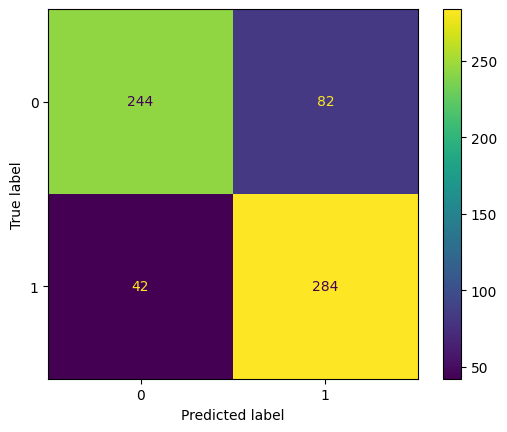

In [22]:
cm_display.plot()
plt.show()

In [23]:
Accuracy = metrics.accuracy_score(y_test, final_pred)
Precision = metrics.precision_score(y_test, final_pred)
Sensitivity_recall = metrics.recall_score(y_test, final_pred)
Specificity = metrics.recall_score(y_test, final_pred, pos_label=0)
F1_score = metrics.f1_score(y_test, final_pred)
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.8098159509202454, 'Precision': 0.7759562841530054, 'Sensitivity_recall': 0.8711656441717791, 'Specificity': 0.7484662576687117, 'F1_score': 0.8208092485549133}


In [24]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [25]:
# Calculate precision, recall, and F1-score for PAC
pac_precision, pac_recall, pac_f1, _ = precision_recall_fscore_support(y_test, pac_pred, average='binary')

# Calculate precision, recall, and F1-score for SGD
sgd_precision, sgd_recall, sgd_f1, _ = precision_recall_fscore_support(y_test, sgd_pred, average='binary')

# Calculate precision, recall, and F1-score for Hoeffding Tree
ht_precision, ht_recall, ht_f1, _ = precision_recall_fscore_support(y_test, ht_pred, average='binary')

# Calculate precision, recall, and F1-score for Gradient Boosting
gb_precision, gb_recall, gb_f1, _ = precision_recall_fscore_support(y_test, final_pred, average='binary')

# Calculate accuracy for PAC, SGD, HT, and Gradient Boosting
pac_accuracy = accuracy_score(y_test, pac_pred)
sgd_accuracy = accuracy_score(y_test, sgd_pred)
ht_accuracy = accuracy_score(y_test, ht_pred)
gb_accuracy = accuracy_score(y_test, final_pred)

# Confusion matrices
pac_conf_matrix = confusion_matrix(y_test, pac_pred)
sgd_conf_matrix = confusion_matrix(y_test, sgd_pred)
ht_conf_matrix = confusion_matrix(y_test, ht_pred)
gb_conf_matrix = confusion_matrix(y_test, final_pred)

# Display results in a structured format
print("Classifier\t\tAccuracy\tPrecision\tRecall\t\tF1-Score")
print("PAC\t\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(pac_accuracy, pac_precision, pac_recall, pac_f1))
print("SGD\t\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(sgd_accuracy, sgd_precision, sgd_recall, sgd_f1))
print("Hoeffding Tree\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(ht_accuracy, ht_precision, ht_recall, ht_f1))
print("Gradient Boosting\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(gb_accuracy, gb_precision, gb_recall, gb_f1))

# Display confusion matrices
print("\nConfusion Matrix for PAC:")
print(pac_conf_matrix)
print("\nConfusion Matrix for SGD:")
print(sgd_conf_matrix)
print("\nConfusion Matrix for Hoeffding Tree:")
print(ht_conf_matrix)
print("\nConfusion Matrix for Gradient Boosting:")
print(gb_conf_matrix)

Classifier		Accuracy	Precision	Recall		F1-Score
PAC			0.7500		0.7245		0.8067		0.7634
SGD			0.8006		0.7784		0.8405		0.8083
Hoeffding Tree		0.7163		0.9490		0.4571		0.6170
Gradient Boosting	0.8098		0.7760		0.8712		0.8208

Confusion Matrix for PAC:
[[226 100]
 [ 63 263]]

Confusion Matrix for SGD:
[[248  78]
 [ 52 274]]

Confusion Matrix for Hoeffding Tree:
[[318   8]
 [177 149]]

Confusion Matrix for Gradient Boosting:
[[244  82]
 [ 42 284]]
